Loads the `de_core_news_md` pipeline and adds the NER component if needed. Registers all entity labels from the training and dev data.
Sets training parameters such as number of iterations, dropout rate, batch strategy, and early stopping threshold based on the data source.
Trains the NER model using minibatches. Evaluates on the dev set after each epoch and applies early stopping if performance plateaus.

📥 Train: 14360 Examples, Dev: 25 Examples
Epoch  1/2 — Loss: 1422.98  |  P:   0.0%  R:   0.0%  F1:   0.0%
Epoch  2/2 — Loss: 1163.61  |  P:   0.0%  R:   0.0%  F1:   0.0%
Notice: High loss and low F1 — model may be underfitting.

Model saved to: /Users/timonmartens/Library/CloudStorage/OneDrive-Persönlich/Desktop/Veranstaltungen/Data Analytics in Applications/daia-eon/notebooks/3_model_training_and_testing/spacy_pipeline/custom_spacy_model_synthetic_data_b___TEST


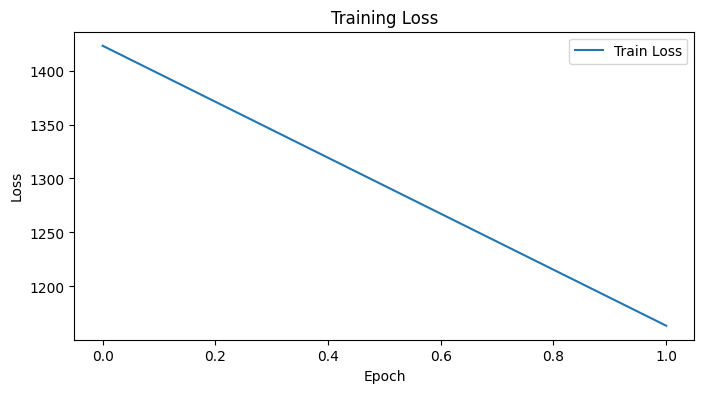

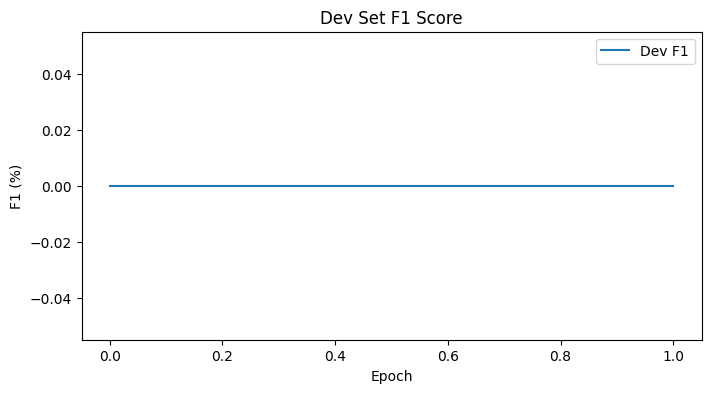

In [3]:
# Step 1: Import required libraries and setup
import spacy
import random
import json
from pathlib import Path
from spacy.training.example import Example
from spacy.util import minibatch, compounding
from spacy.scorer import Scorer
import matplotlib.pyplot as plt


# Step 2: Define a helper function to load annotated training or dev data from a JSON file
def load_data_from_json(path):
    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)
    if isinstance(raw, dict):
        raw = [raw]
    out = []
    for entry in raw:
        ents = [(lab["start"], lab["end"], lab["label"]) for lab in entry["labels"]]
        out.append((entry["text"], {"entities": ents}))
    return out


# Load training and development datasets
train_data = load_data_from_json("../../../data/synthetic/synthetic_mails_option_b_cleaned.json")
dev_data = load_data_from_json("../../../data/original/ground_truth_split/validation_norm.json")
print(f"📥 Train: {len(train_data)} Examples, Dev: {len(dev_data)} Examples")

# Alternative training sets:
# train_data = load_data_from_json("../../../data/original/ground_truth_split/train_norm.json")   # Real data

# Step 3: Load base spaCy model and initialize the NER component
nlp = spacy.load("de_core_news_md")
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe("ner")

# Register all entity labels from both training and dev data with the NER pipeline
for data in (train_data, dev_data):
    for _, ann in data:
        for start, end, label in ann["entities"]:
            ner.add_label(label)

# Resume training (activates or continues optimizer for the pipeline)
optimizer = nlp.resume_training()


# Define a helper function to evaluate the model on the dev set using spaCy's scorer
def evaluate_dev(nlp, data):
    scorer = Scorer()
    examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in data]
    scores = scorer.score(examples)
    # gesamt (macro) ausgeben, sowie pro Label wenn gewünscht
    return scores["ents_p"], scores["ents_r"], scores["ents_f"]


# Step 4: Train the NER component with evaluation and early stopping
# Parameters for synthetic training data
n_iter = 30  # number of training epochs
dropout = 0.2  # dropout rate for regularization
batch_compound = compounding(8.0, 64.0, 1.001)  # batch size scheduler
early_stopping_rounds = 5  # stop early if F1 doesn't improve for 5 consecutive epochs

# Alternative parameters for real data
# n_iter = 15
# dropout = 0.3
# batch_compound = compounding(4.0, 32.0, 1.001)
# early_stopping_rounds = 3

loss_history = []
f1_history = []
best_f1 = 0.0
no_improve = 0

for i in range(n_iter):
    # Shuffle training data at the beginning of each epoch
    random.shuffle(train_data)
    losses = {}

    # Divide training data into minibatches and update the model
    batches = minibatch(train_data, size=batch_compound)
    for batch in batches:
        exs = [Example.from_dict(nlp.make_doc(t), ann) for t, ann in batch]
        nlp.update(exs, drop=dropout, losses=losses)

    # Track loss for this epoch
    loss = losses.get("ner", 0.0)
    loss_history.append(loss)

    # Evaluate model on the dev set
    p, r, f = evaluate_dev(nlp, dev_data)
    f1_history.append(f)

    # Print training and validation performance
    print(
        f"Epoch {i + 1:2d}/{n_iter} — Loss: {loss:7.2f}  |  P: {p * 100:5.1f}%  R: {r * 100:5.1f}%  F1: {f * 100:5.1f}%")

    ## Heuristic warnings for overfitting or underfitting
    if i > 0:
        if loss_history[-1] < loss_history[-2] and f1_history[-1] < f1_history[-2]:
            print("Warning: Training loss decreased while F1 score also decreased — potential overfitting.")
        if loss > 1000 and f < 0.3:
            print("Notice: High loss and low F1 — model may be underfitting.")

    # Early stopping logic based on F1 score improvement
    if f > best_f1:
        best_f1 = f
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= early_stopping_rounds:
            print(
                f"Early stopping after {i + 1} epochs — no F1 improvement for {early_stopping_rounds} consecutive rounds")
            break

# Step 5: Save the final model to disk (Link to be adapted depending on training data)
#out_dir = Path("custom_spacy_model_synthetic_data_b")
out_dir = Path("custom_spacy_model_synthetic_data_b")
out_dir.mkdir(exist_ok=True)
nlp.to_disk(out_dir)
print(f"\nModel saved to: {out_dir.resolve()}")

# Step 6: Plot training loss and dev F1 over epochs
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label="Train Loss")
plt.ylabel("Loss");
plt.xlabel("Epoch");
plt.legend();
plt.title("Training Loss")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot([v * 100 for v in f1_history], label="Dev F1")
plt.ylabel("F1 (%)");
plt.xlabel("Epoch");
plt.legend();
plt.title("Dev Set F1 Score")
plt.show()

Evaluates a model on labeled examples, returning a pandas DataFrame with precision, recall, F1, and error counts per label, plus micro/macro averages.

In [4]:
from spacy.training import Example
from spacy.scorer import Scorer
import pandas as pd
from collections import defaultdict


def evaluate_model_with_counts(nlp, examples):
    # Initialize the spaCy scorer and a container for evaluation examples
    scorer = Scorer()
    example_list = []

    # Initialize a dictionary to track true positives, false positives, and false negatives per label
    counts = defaultdict(lambda: {"tp": 0, "fp": 0, "fn": 0})

    # Iterate over all annotated evaluation examples
    for text, ann in examples:
        doc = nlp(text)
        example = Example.from_dict(doc, ann)

        # Extract predicted and true entities as sets of (start, end, label)
        pred_ents = {(ent.start_char, ent.end_char, ent.label_) for ent in example.predicted.ents}
        true_ents = {(ent.start_char, ent.end_char, ent.label_) for ent in example.reference.ents}

        # Compare predicted to true entities and update counts
        for ent in pred_ents:
            if ent in true_ents:
                counts[ent[2]]["tp"] += 1
            else:
                counts[ent[2]]["fp"] += 1
        for ent in true_ents:
            if ent not in pred_ents:
                counts[ent[2]]["fn"] += 1

        example_list.append(example)

    # Use spaCy's built-in scoring for additional metrics
    scores = scorer.score(example_list)
    results = []

    # Initialize totals for micro-averaging
    sum_tp = sum_fp = sum_fn = 0
    all_precisions = []
    all_recalls = []
    all_f1s = []

    # Collect precision, recall, F1, and counts per entity label
    for label, metrics in scores["ents_per_type"].items():
        tp = counts[label]["tp"]
        fp = counts[label]["fp"]
        fn = counts[label]["fn"]

        sum_tp += tp
        sum_fp += fp
        sum_fn += fn

        precision = metrics["p"] * 100
        recall = metrics["r"] * 100
        f1 = metrics["f"] * 100

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

        results.append({
            "Label": label,
            "Precision (%)": round(precision, 2),
            "Recall (%)": round(recall, 2),
            "F1-Score (%)": round(f1, 2),
            "True Positives": tp,
            "False Positives": fp,
            "False Negatives": fn
        })

    # Add macro-average row (unweighted average over all labels)
    if all_precisions:
        results.append({
            "Label": "⚙️ Overall (Macro-Average)",
            "Precision (%)": round(sum(all_precisions) / len(all_precisions), 2),
            "Recall (%)": round(sum(all_recalls) / len(all_recalls), 2),
            "F1-Score (%)": round(sum(all_f1s) / len(all_f1s), 2),
            "True Positives": "-",
            "False Positives": "-",
            "False Negatives": "-"
        })

    # Add micro-average row (global TP, FP, FN)
    if (sum_tp + sum_fp) > 0 and (sum_tp + sum_fn) > 0:
        precision_micro = sum_tp / (sum_tp + sum_fp)
        recall_micro = sum_tp / (sum_tp + sum_fn)
        f1_micro = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro)
        results.append({
            "Label": "📦 Overall (Micro-Average)",
            "Precision (%)": round(precision_micro * 100, 2),
            "Recall (%)": round(recall_micro * 100, 2),
            "F1-Score (%)": round(f1_micro * 100, 2),
            "True Positives": sum_tp,
            "False Positives": sum_fp,
            "False Negatives": sum_fn
        })

    # Return results as a Pandas DataFrame for display or export
    return pd.DataFrame(results)

In [7]:
# Load three different trained spaCy models from disk for comparison
nlp = spacy.load("models/custom_spacy_model_original_data_17072025_21_46_transfer")
nlp2 = spacy.load("models/custom_spacy_model_synthetic_data_b_push")

# Evaluate each model on the same development dataset
results_nlp = evaluate_model_with_counts(nlp, dev_data)
results_nlp2 = evaluate_model_with_counts(nlp2, dev_data)

# Display evaluation results as dataframes (precision, recall, F1 per label and aggregated)
display(results_nlp)
display(results_nlp2)


,Label,Precision (%),Recall (%),F1-Score (%),True Positives,False Positives,False Negatives
0,VORNAME,92.00,88.46,90.20,23,2,3
1,NACHNAME,82.76,85.71,84.21,24,5,4
2,VERTRAGSNUMMER,63.16,92.31,75.00,12,7,1
3,TELEFONNUMMER,40.00,100.00,57.14,2,3,0
4,DATUM,85.71,72.00,78.26,18,3,7
5,STRASSE,60.00,75.00,66.67,3,2,1
6,HAUSNUMMER,75.00,75.00,75.00,3,1,1
7,POSTLEITZAHL,100.00,100.00,100.00,4,0,0
8,WOHNORT,80.00,100.00,88.89,4,1,0
9,FAX,0.00,0.00,0.00,0,0,2


,Label,Precision (%),Recall (%),F1-Score (%),True Positives,False Positives,False Negatives
0,VORNAME,100.00,96.15,98.04,25,0,1
1,NACHNAME,96.43,96.43,96.43,27,1,1
2,VERTRAGSNUMMER,85.71,92.31,88.89,12,2,1
3,ZÄHLERNUMMER,80.00,66.67,72.73,4,1,2
4,FIRMA,42.86,60.00,50.00,3,4,2
5,STRASSE,100.00,75.00,85.71,3,0,1
6,HAUSNUMMER,42.86,75.00,54.55,3,4,1
7,POSTLEITZAHL,100.00,100.00,100.00,4,0,0
8,WOHNORT,100.00,100.00,100.00,4,0,0
9,TELEFONNUMMER,100.00,100.00,100.00,2,0,0
